<a href="https://colab.research.google.com/github/emartinmorgan/OPPlogfileanalysis/blob/main/logpreghigh_sankey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Sankey Tutorial](https://towardsdatascience.com/visualizing-in-app-user-journey-using-sankey-diagrams-in-python-8373a7bb2d22)

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install chart_studio
import pandas as pd
import numpy as np
# import chart_studio.plotly as cspy
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# import chart_studio.plotly as py
import plotly.graph_objects as go

import plotly.express as px
# import chart_studio.plotly as py
import plotly

import seaborn as se
from google.colab import files
print("hello world")

hello world


In [ ]:
high = pd.read_csv("/content/drive/MyDrive/OSU - BMI/Fareed Lab/Thesis/Data_Final/Sankey/sank_high_fin.csv")
high

,pat_epi,clus_high_id,clus_high,tri
0,32.1,1.0,Average Users,1
1,37.1,2.0,Exclusive Resulters,1
2,38.1,3.0,Intense Digital Engagers,1
3,52.1,4.0,Average Users,1
4,55.1,5.0,Average Users,1
...,...,...,...,...
5719,17355.1,1427.0,Resulters,4
5720,17384.1,1428.0,Resulters,4
5721,17391.1,1429.0,Intense Digital Engagers,4
5722,17397.1,1430.0,Intense Digital Engagers,4


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

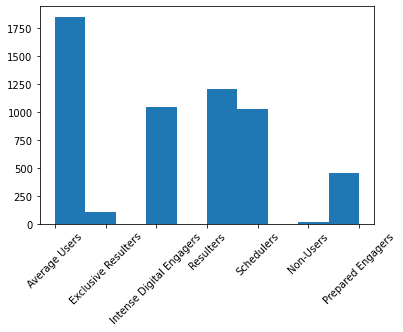

In [ ]:
plt.hist(high.clus_high,bins=10)
plt.xticks(rotation = 45)

In [ ]:
# Based on the tri, we can compute the rank of each cluster at the pat_epi level:

# a) Sort ascendingly per pat_epi and tri

high.sort_values(['pat_epi', 'tri'],
                 ascending=[True, True], inplace=True)
high.head()

,pat_epi,clus_high_id,clus_high,tri
0,32.1,1.0,Average Users,1
1431,32.1,1.0,Schedulers,2
2862,32.1,1.0,Average Users,3
4293,32.1,1.0,Prepared Engagers,4
1,37.1,2.0,Exclusive Resulters,1


In [ ]:
high=high[high.tri!=4]

In [ ]:
# b) Define a ranking function based on tri, using the method = 'first' param to ensure no clusters have the same rank

# def rank(x): return x['tri'].rank(method='first').astype(int)

# c) Group by user_id 
grouped = high.groupby('pat_epi')

# d) Apply the ranking function to the all DF into a new "rank_clus" column
# high["rank_clus"] = grouped.apply(rank).reset_index(0, drop=True)

# e) The shift function allows to access the next row's data. Here, we'll want the cluster name
def get_next_clus(x): return x['clus_high'].shift(-1)

# f) Apply the function into a new "next_clus" column
high["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

# g) Regroup by user_id 
grouped = high.groupby('pat_epi')
high.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,pat_epi,clus_high_id,clus_high,tri,next_clus
0,32.1,1.0,Average Users,1,Schedulers
1431,32.1,1.0,Schedulers,2,Average Users
2862,32.1,1.0,Average Users,3,NaN
1,37.1,2.0,Exclusive Resulters,1,Resulters
1432,37.1,2.0,Resulters,2,Resulters


We attribute a unique color to each event, and name this dict nodes_dict.

In [ ]:
# Working on the nodes_dict

high_clus = list(high.clus_high.unique())

# Create a set of colors that you'd like to use in your plot.
palette = ['50BE97', 'E4655C', 'FBEEAC', '3E5066',
           'BFD6DE', 'FCC865', '353A3E', 'E6E6E6']
#  Here, I passed the colors as HEX, but we need to pass it as RGB. This loop will convert from HEX to RGB:
for i, col in enumerate(palette):
    palette[i] = tuple(int(col[i:i+2], 16) for i in (0, 2, 4))

# Append a Seaborn complementary palette to your palette in case you did not provide enough colors to style every event
# complementary_palette = se.color_palette("deep", len(all_events) - len(palette))
# if len(complementary_palette) > 0:
#     palette.extend(complementary_palette)

output = dict()
output.update({'nodes_dict': dict()})

i = 0
for tri in high.tri.unique(): # For each tri of clus...
    # Create a new key equal to the tri...
    output['nodes_dict'].update(
        {tri: dict()}
    )
    
    # Look at all the events that were done at this step of the funnel...
    high_clus_at_this_tri = high[high.tri ==
                                   tri].clus_high.unique()
    
    # Read the colors for these events and store them in a list...
    tri_palette = []
    for clus in high_clus_at_this_tri:
        tri_palette.append(palette[list(high_clus).index(clus)])
    
    # Keep trace of the events' names, colors and indices.
    output['nodes_dict'][tri].update(
        {
            'sources': list(high_clus_at_this_tri),
            'color': tri_palette,
            'sources_index': list(range(i, i+len(high_clus_at_this_tri)))
        }
    )
    # Finally, increment by the length of this rank's available clus to make sure next indices will not be chosen from existing ones
    i += len(output['nodes_dict'][tri]['sources_index'])

In [ ]:
high_clus_at_this_tri

array(['Average Users', 'Resulters', 'Schedulers',
       'Intense Digital Engagers', 'Non-Users'], dtype=object)

In [ ]:
# Working on the links_dict

output.update({'links_dict': dict()})

# Group the DataFrame by pat_epi and tri
grouped = high.groupby(['pat_epi', 'tri'])

# Define a function to read the souces, targets, values clus_high to next_clus:
def update_source_target(user):
    try:
        # user.name[0] is the user's pat_epi; user.name[1] is the tri
        # 1st we retrieve the source and target's indices from nodes_dict
        source_index = output['nodes_dict'][user.name[1]]['sources_index'][output['nodes_dict']
                                                                           [user.name[1]]['sources'].index(user['clus_high'].values[0])]
        target_index = output['nodes_dict'][user.name[1] + 1]['sources_index'][output['nodes_dict']
                                                                               [user.name[1] + 1]['sources'].index(user['next_clus'].values[0])]

         # If this source is already in links_dict...
        if source_index in output['links_dict']:
            # ...and if this target is already associated to this source...
            if target_index in output['links_dict'][source_index]:
                # ...then we increment the count of users with this source/target pair by 1
                output['links_dict'][source_index][target_index]['unique_users'] += 1
            # ...but if the target is not already associated to this source...
            else:
                # ...we create a new key for this target, for this source, and initiate it with 1 user and the time from source to target
                output['links_dict'][source_index].update({target_index:
                                                           dict(
                                                               {'unique_users': 1}
                                                            )
                                                           })
        # ...but if this source isn't already available in the links_dict, we create its key and the key of this source's target, and we initiate it with 1 user and the time from source to target
        else:
            output['links_dict'].update({source_index: dict({target_index: dict(
                {'unique_users': 1})})})
    except Exception as e:
        pass

# Apply the function to your grouped Pandas object:
grouped.apply(lambda user: update_source_target(user)) 



""


In [ ]:
high.head()

,pat_epi,clus_high_id,clus_high,tri,next_clus
0,32.1,1.0,Average Users,1,Schedulers
1431,32.1,1.0,Schedulers,2,Average Users
2862,32.1,1.0,Average Users,3,NaN
1,37.1,2.0,Exclusive Resulters,1,Resulters
1432,37.1,2.0,Resulters,2,Resulters


In [ ]:
high.groupby(['clus_high','tri']).count()

pat_epi  clus_high_id  next_clus
clus_high                tri                                  
Average Users            1        610           610        610
                         2        688           688        688
                         3        558           558          0
Exclusive Resulters      1        107           107        107
Intense Digital Engagers 1        254           254        254
                         2        297           297        297
                         3        273           273          0
Non-Users                1         10             0         10
                         2          2             0          2
                         3          4             0          0
Resulters                1        262           262        262
                         2        100           100        100
                         3        290           290          0
Schedulers               1        188           188        188
                         2        344           344        344
                         3        306           306          0

In [ ]:
targets = []
sources = []
values = []

for source_key, source_value in output['links_dict'].items():
    for target_key, target_value in output['links_dict'][source_key].items():
        sources.append(source_key)
        targets.append(target_key)
        values.append(target_value['unique_users'])
        
labels = []
colors = []

for key, value in output['nodes_dict'].items():
    labels = labels + list(output['nodes_dict'][key]['sources']) 
    colors = colors + list(output['nodes_dict'][key]['color'])
for idx, color in enumerate(colors):
    colors[idx] = "rgb" + str(color) + ""


In [ ]:
cc=high.groupby(['clus_high','tri']).count()
cc=cc.reset_index()
cc.groupby(by='tri').sum()

,pat_epi,clus_high_id,next_clus
tri,,,
1,1431,1421,1431
2,1431,1429,1431
3,1431,1427,0


In [ ]:
cc['tri'].sort_values()

0     1
3     1
4     1
7     1
10    1
13    1
1     2
5     2
8     2
11    2
14    2
2     3
6     3
9     3
12    3
15    3
Name: tri, dtype: int64

In [ ]:
labels

['Average Users',
 'Exclusive Resulters',
 'Intense Digital Engagers',
 'Resulters',
 'Schedulers',
 'Non-Users',
 'Schedulers',
 'Resulters',
 'Average Users',
 'Intense Digital Engagers',
 'Non-Users',
 'Average Users',
 'Resulters',
 'Schedulers',
 'Intense Digital Engagers',
 'Non-Users']

In [ ]:
cc=high.groupby(['clus_high','tri']).count()
cc=cc.reset_index()
# cc
cc=cc.sort_values(['tri'])
x=cc[cc.tri==1]['pat_epi']/1431
x=np.append(x,cc[cc.tri==2]['pat_epi']/1431)
x=np.append(x,cc[cc.tri==3]['pat_epi']/1431)
cc['perc']=(np.round(x*100)).astype(int)

cc['aa']=' ('
cc['bb']='%)'
cc=cc.iloc[[0,1,2,4,5,3,10,9,6,7,8,11,14,15,12,13],:]#4,0,1,2,5,3,8,7,9,6,10,15,11,14,13,16,12,18,19,17,21,20],:]
a=np.char.array(cc['clus_high'].values)
b=np.char.array(cc['tri'].values)
c=np.char.array(cc['pat_epi'].values)
d=np.char.array(cc['perc'].values)
e=np.char.array(cc['aa'].values)
f=np.char.array(cc['bb'].values)
labels=(a + b' : ' + c + e + d + f).astype(str)
# cc['clus_all'].astype('str')+cc['tri'].astype('str')+cc['pat_epi'].astype('str')
# np.array(cc[['clus_all','tri']]).to_list()

In [ ]:
cc.reset_index()

,index,clus_high,tri,pat_epi,clus_high_id,next_clus,perc,aa,bb
0,0,Average Users,1,610,610,610,43,(,%)
1,3,Exclusive Resulters,1,107,107,107,7,(,%)
2,4,Intense Digital Engagers,1,254,254,254,18,(,%)
3,7,Non-Users,1,10,0,10,1,(,%)
4,10,Resulters,1,262,262,262,18,(,%)
5,13,Schedulers,1,188,188,188,13,(,%)
6,1,Average Users,2,688,688,688,48,(,%)
7,5,Intense Digital Engagers,2,297,297,297,21,(,%)
8,8,Non-Users,2,2,0,2,0,(,%)
9,11,Resulters,2,100,100,100,7,(,%)


In [ ]:
# label = ["{} {}".format(node1_name, node1_val), "{} {}".format(node2_name, node2_val) ...]
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=20,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        hovertemplate='%{value} unique pregnancy episodes went from %{source.label} to %{target.label}.<br />',
    ))])

fig.update_layout(autosize=True, title=dict(text="Movement of Clusters Among High-Risk Pregnancies", font_size=16), font=dict(size=12, family="Arial"), plot_bgcolor='white')
fig.show()